In [1]:
import gzip
import random
import numpy as np
from collections import defaultdict
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LogisticRegression
import warnings
warnings.filterwarnings('ignore')

In [2]:
def readGz(path):
    for l in gzip.open(path, 'rt'):
        yield eval(l)

def readCSV(path):
    f = gzip.open(path, 'rt')
    f.readline()
    for l in f:
        yield l.strip().split(',')

In [3]:
example = readCSV("train_Interactions.csv.gz")
print(next(example))
del example

['u79354815', 'b14275065', '4']


# Question 1

In [4]:
### Would-read baseline: just rank which books are 
### popular and which are not, and return '1' if a
### book is among the top-ranked
train_size = 190000
val_size   = 10000

data = [line for line in readCSV("train_Interactions.csv.gz")]
train = data[:train_size]
val   = data[train_size:]
print(len(data))
print(len(train))
print(len(val))

200000
190000
10000


In [5]:
booksReadBy = defaultdict(set)
train_booksReadBy = defaultdict(set)
val_booksReadBy = defaultdict(set)
usersReadBook = defaultdict(set)
val_usersReadBook = defaultdict(set)
train_usersReadBook = defaultdict(set)
all_books = set()
val_all_books = set()
train_all_books = set()
    
for user, book, _ in data:
    all_books.add(book)
    usersReadBook[book].add(user)
    booksReadBy[user].add(book)

for user, book, _ in train:
    train_all_books.add(book)
    train_usersReadBook[book].add(user)
    train_booksReadBy[user].add(book)

for user, book, _ in val:
    val_all_books.add(book)
    val_usersReadBook[book].add(user)
    val_booksReadBy[user].add(book)

val_unread = []
all_books_count = len(all_books)
for user, book, _ in val: 
    unread_book = random.sample(all_books, 1)
    while(unread_book in list(booksReadBy[user])):
        unread_book = random.sample(all_books, 1)
    val_unread.append([user, str(unread_book[0]), '-1'])

val = val + val_unread
print(len(val))
print(val[0:3])

20000
[['u35176258', 'b30592470', '3'], ['u30851063', 'b81941226', '3'], ['u31368414', 'b40097012', '5']]


In [6]:
bookCount = defaultdict(int)
total_books_read = 0

for user, book, _ in train:
    bookCount[book]  += 1
    total_books_read += 1

mostPopular = [(bookCount[book], book) for book in bookCount]
mostPopular.sort()
mostPopular.reverse()

In [7]:
def popular_books_set(mostPopular, threshold_ratio):
    return1 = set()
    cur_book_count = 0
    for book_count, book in mostPopular:
        cur_book_count += book_count
        return1.add(book)
        if cur_book_count > total_books_read *\
        threshold_ratio: 
            break
    return return1

In [8]:
def jaccard(set1, set2):
    """
    Returns the Jaccard similarity between two sets,
    set1 & set2
    """
    set_intersection = len(set1.intersection(set2))
    set_union = len(set1.union(set2))
    if set_union == 0:
        return 0
    else:
        return set_intersection / set_union

In [9]:
def jaccard_prediction(jac_sims):
    """
    Returns the Jaccard similarity between two sets,
    set1 & set2
    """
    prediction = False
    if jac_sims != []:
        prediction = max(jac_sims) >= jaccard_threshold
    return prediction

In [10]:
def calc_jac(user, book_predict):
    books_user_read = train_booksReadBy[user]
    jac_sims = []
    for users_book in books_user_read:   
        users_read_book_predict = train_usersReadBook[book_predict]
        users_read_users_book = train_usersReadBook[users_book]
        jac_sim = jaccard(users_read_book_predict, users_read_users_book)
        jac_sims.append(jac_sim)
    return jac_sims

In [11]:
# bookScores = defaultdict(int)
# # for user, book, rating in train_LR:
# #     bookScores[book] = (rating >= 0) * 2 - 1

allRatings = []
userBookRatings = defaultdict(lambda: defaultdict(float))
userRatings = defaultdict(list)
userBooks   = defaultdict(set)
bookUsers   = defaultdict(set)

for user, book, rating in train:
    rating = int(rating)
    allRatings.append(rating)
    userRatings[user].append(rating)
    userBookRatings[user][book] = rating
    userBooks[user].add(book)
    bookUsers[book].add(user)

In [12]:
def cos_sim(book1, book2):
    globalAverage = 3.897121052631579
    users_read_both = list(train_usersReadBook[book1]) + list(train_usersReadBook[book2])
    users_read_both = set(users_read_both)
    book1_ratings = 0
    book2_ratings = 0
    zero_users = set()
    for user in users_read_both:
        if userBookRatings[user][book1] == 0: zero_users.add(user)
        if userBookRatings[user][book2] == 0: zero_users.add(user)
    for zero_user in zero_users:
        users_read_both.remove(zero_user)

    if len(users_read_both) == 0: return 0
    numerator_sum = 0; denom_sum1 = 0; denom_sum2 = 0
    
    for user in users_read_both:
        arg1 = (userBookRatings[user][book1] > globalAverage) * 2 - 1
        arg2 = (userBookRatings[user][book2] > globalAverage) * 2 - 1
        numerator_sum += arg1 * arg2
        denom_sum1 += arg1 ** 2
        denom_sum2 += arg2 ** 2
        
    denom = denom_sum1 * denom_sum2
    if denom == 0: return 0
    cosine_sim = numerator_sum / (denom ** 0.5)
    return cosine_sim

def pearson_sim(book1, book2):
    users_read_both = list(train_usersReadBook[book1]) + list(train_usersReadBook[book2])
    users_read_both = set(users_read_both)
    book1_ratings = 0
    book2_ratings = 0
#     zero_users = set()
#     for user in users_read_both:
#         if userBookRatings[user][book1] == 0: zero_users.add(user)
#         if userBookRatings[user][book2] == 0: zero_users.add(user)
#     for zero_user in zero_users:
#         users_read_both.remove(zero_user)
    
    if len(users_read_both) == 0: return 0

    for user in users_read_both:
        book1_ratings += userBookRatings[user][book1]
        book2_ratings += userBookRatings[user][book2]
    
    book1_ratings = book1_ratings / len(users_read_both)
    book2_ratings = book2_ratings / len(users_read_both)
#     print(len(users_read_both))   
#     print(book1_ratings, book2_ratings)
    numerator_sum = 0; denom_sum1 = 0; denom_sum2 = 0
    for user in users_read_both:
        arg1 = (userBookRatings[user][book1] - book1_ratings)
        arg2 = (userBookRatings[user][book2] - book2_ratings)
        numerator_sum += arg1 * arg2
        denom_sum1 += arg1 ** 2
        denom_sum2 += arg2 ** 2
        
    denom = denom_sum1 * denom_sum2
    if denom == 0: return 0
    pearson_sim = numerator_sum / (denom ** 0.5)
    return pearson_sim

def pearson_simv2(user1, user2):
    books_read_byboth = list(train_booksReadBy[user1]) + list(train_booksReadBy[user2])
    books_read_byboth = set(books_read_byboth)
    user1_ratings = 0
    user2_ratings = 0
#     zero_books = set()
#     for book in books_read_byboth:
#         if userBookRatings[user1][book] == 0: zero_books.add(book)
#         if userBookRatings[user2][book] == 0: zero_books.add(book)
#     for zero_book in zero_books:
#         books_read_byboth.remove(zero_book)
    
    if len(books_read_byboth) == 0: return 0

    for book in books_read_byboth:
        user1_ratings += userBookRatings[user1][book]
        user2_ratings += userBookRatings[user2][book]
    
    user1_ratings = user1_ratings / len(books_read_byboth)
    user2_ratings = user2_ratings / len(books_read_byboth)
    numerator_sum = 0; denom_sum1 = 0; denom_sum2 = 0
    for book in books_read_byboth:
        arg1 = (userBookRatings[user1][book] - user1_ratings)
        arg2 = (userBookRatings[user2][book] - user2_ratings)
        numerator_sum += arg1 * arg2
        denom_sum1 += arg1 ** 2
        denom_sum2 += arg2 ** 2
        
    denom = denom_sum1 * denom_sum2
    if denom == 0: return 0
    pearson_sim = numerator_sum / (denom ** 0.5)
    return pearson_sim

def calc_pearson(user, book_predict):
    books_user_read = train_booksReadBy[user]
    pears_sims = []
    for users_book in books_user_read:  
        pears_sim = pearson_sim(users_book, book_predict)
        pears_sims.append(pears_sim)
    return pears_sims

def calc_pearson_train(user, book_predict):
    books_user_read = train_booksReadBy[user]
    pears_sims = []
    for users_book in books_user_read:  
        if users_book == book_predict: continue
        pears_sim = pearson_sim(users_book, book_predict)
        pears_sims.append(pears_sim)
    return pears_sims

def calc_cosine(user, book_predict):
    books_user_read = train_booksReadBy[user]
    cosine_sims = []
    for users_book in books_user_read:  
        cosine_sim = cos_sim(users_book, book_predict)
        cosine_sims.append(cosine_sim)
    return cosine_sims

def calc_cosine_train(user, book_predict):
    books_user_read = train_booksReadBy[user]
    cosine_sims = []
    for users_book in books_user_read:  
        if users_book == book_predict: continue
        cosine_sim = cos_sim(users_book, book_predict)
        cosine_sims.append(cosine_sim)
    return cosine_sims


def calc_jac_train(user, book_predict):
    books_user_read = train_booksReadBy[user]
    jac_sims = []
    for users_book in books_user_read:  
        if users_book == book_predict: continue
        users_read_book_predict = train_usersReadBook[book_predict]
        users_read_users_book = train_usersReadBook[users_book]
        jac_sim = jaccard(users_read_book_predict, users_read_users_book)
        jac_sims.append(jac_sim)
    return jac_sims

def calc_jac(user, book_predict):
    books_user_read = train_booksReadBy[user]
    jac_sims = []
    for users_book in books_user_read:   
        users_read_book_predict = train_usersReadBook[book_predict]
        users_read_users_book = train_usersReadBook[users_book]
        jac_sim = jaccard(users_read_book_predict, users_read_users_book)
        jac_sims.append(jac_sim)
    return jac_sims

def calc_pearsonv2(user, book):
    users_read_book = train_usersReadBook[book]
    pears_sims = []
    for user_r in users_read_book:  
        pears_sim = pearson_simv2(user, user_r)
        pears_sims.append(pears_sim)
    return pears_sims

def calc_pearson_trainv2(user, book):
    users_read_book = train_usersReadBook[book]
    pears_sims = []
    for user_r in users_read_book:  
        if user_r == user: continue
        pears_sim = pearson_simv2(user, user_r)
        pears_sims.append(pears_sim)
    return pears_sims

In [13]:
def feature(datum, func1, func2, func3):
    user, book, _ = datum
    feat = [1]
    jac_sims = func1(user, book)
    if len(jac_sims) == 0: jac_val = 0
    else: jac_val = max(jac_sims)
    feat.append(jac_val)
    pop_val = book in return1
    feat.append(pop_val)
    
#     pears_sims = func2(user, book)
#     if len(pears_sims) == 0: pears_sim = 0
#     else: 
#         pears_sim = max(pears_sims)
#         if pears_sim == 1: pears_sim = 0 # Only one book in common, what to do?
#     feat.append(pears_sim)
         
#     cosine_sims = func2(user, book)
#     if len(cosine_sims) == 0: cosine_sim = 0
#     else: 
#         cosine_sim = max(cosine_sims)
#         # if abs(cosine_sim == 1): cosine_sim = 0
#     feat.append(cosine_sim)
    return feat

In [14]:
train_LR = train
train_unread = []

for user, book, _ in train: 
    unread_book = random.sample(all_books, 1)
    while(unread_book in list(booksReadBy[user])):
        unread_book = random.sample(all_books, 1)
    train_unread.append([user, str(unread_book[0]), '-1'])
train_LR = train + train_unread

In [15]:
# random.shuffle(train_LR)
# train_LR = train_LR[:50000]

In [16]:
return1 = popular_books_set(mostPopular, 0.64)
loop_count = 0
LR_feat_train = []
print('here')
for d in train_LR:
    loop_count += 1
    if loop_count % 10000 == 0: print(loop_count, end = ', ');
    LR_feat_train.append(feature(d, calc_jac_train, calc_cosine_train, _))

here
10000, 20000, 30000, 40000, 50000, 60000, 70000, 80000, 90000, 100000, 110000, 120000, 130000, 140000, 150000, 160000, 170000, 180000, 190000, 200000, 210000, 220000, 230000, 240000, 250000, 260000, 270000, 280000, 290000, 300000, 310000, 320000, 330000, 340000, 350000, 360000, 370000, 380000, 

In [17]:
# LR_feat_train   = np.array([feature(d, calc_jac_train, calc_pearson_train, calc_cosine_train) for d in train_LR])
LR_feat_train = np.array(LR_feat_train)
LR_labels_train = [int(rating) >= 0 for _, _, rating in train_LR]
LR_feat_val  = np.array([feature(d, calc_jac, calc_cosine, _) for d in val])
LR_labels_val = [int(rating) >= 0 for _, _, rating in val]

In [18]:
C_values = np.logspace(-2, -1, num = 40)
accs = []
loop_count = 0
for C_value in C_values:
    loop_count += 1
    if loop_count % 10 == 0: print(loop_count, end = ', ')
    clf = LogisticRegression(C = C_value).fit(LR_feat_train, LR_labels_train)
    acc = clf.score(LR_feat_val, LR_labels_val)
    accs.append(acc)

10, 20, 30, 40, 

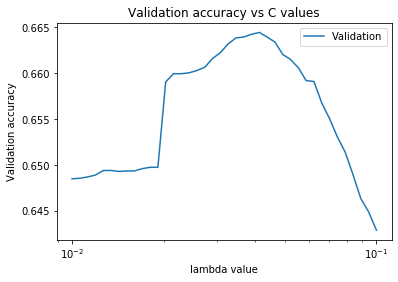


C value for highest accuracy is: 0.04124626382901352
Best validation accuracy is: 0.66445


In [19]:
plt.plot(C_values, accs, label='Validation')
plt.ylabel('Validation accuracy')
plt.xlabel('lambda value'), plt.xscale('log')
plt.title('Validation accuracy vs C values')
plt.legend()
plt.show()

indx = accs.index(max(accs))
print('\nC value for highest accuracy is:', C_values[indx])
print('Best validation accuracy is:', accs[indx])

In [20]:
clf = LogisticRegression(C = C_values[indx]).fit(LR_feat_train, LR_labels_train)
def predict_datapoint_new(user, book_predict):
    feat = np.array(feature((user, book_predict,_), calc_jac, calc_cosine, _))
    feat = feat.reshape(1, -1)
    prediction = clf.predict(feat)       
    return prediction

with open("predictions_Read.txt", 'w') as predictions:
    for l in open("pairs_Read.txt"):
        if l.startswith("userID"): # it's just the header
            predictions.write(l)
            continue
        user, book = l.strip().split('-') # it is a datapoint
        prediction = predict_datapoint_new(user, book)
        if prediction:
            predictions.write(user + '-' + book + ",1\n")
        else:
            predictions.write(user + '-' + book + ",0\n")